In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta, datetime, date
import seaborn as sns
import plotly.express as px
%matplotlib inline
import requests
from urllib.parse import urlencode

# Проект: вариант 1

# Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

### Выгрузка и предобработка данных

In [2]:
# считываем исходные данные
df_reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-markovicheva-26/shared/problem1-reg_data.csv', sep=';')
df_auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-markovicheva-26/shared/problem1-auth_data.csv', sep=';')

# проверка вывода данных о регистрации
df_reg_data.head()

reg_ts  uid
0  911382223    1
1  932683089    2
2  947802447    3
3  959523541    4
4  969103313    5

In [3]:
df_reg_data.shape

(1000000, 2)

In [4]:
# проверка на отсутствие значений
df_reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [5]:
# проверка на отсутствие дубликатов
df_reg_data.duplicated().sum()

0

In [6]:
df_reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [7]:
# приводим колонку reg_ts к формату datetime
df_reg_data.reg_ts = pd.to_datetime(df_reg_data.reg_ts, unit='s')
df_reg_data.head()

reg_ts  uid
0 1998-11-18 09:43:43    1
1 1999-07-22 22:38:09    2
2 2000-01-13 22:27:27    3
3 2000-05-28 14:19:01    4
4 2000-09-16 11:21:53    5

In [8]:
# проверка вывода данных о времени захода пользователей в игру
df_auth_data.head()

auth_ts  uid
0  911382223    1
1  932683089    2
2  932921206    2
3  933393015    2
4  933875379    2

In [9]:
df_auth_data.shape

(9601013, 2)

In [10]:
# проверка на отсутствие значений
df_auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [11]:
# проверка на отсутствие дубликатов
df_auth_data.duplicated().sum()

0

In [12]:
# приводим колонку auth_ts к формату datetime
df_auth_data.auth_ts = pd.to_datetime(df_auth_data.auth_ts, unit='s')
df_auth_data.head()

auth_ts  uid
0 1998-11-18 09:43:43    1
1 1999-07-22 22:38:09    2
2 1999-07-25 16:46:46    2
3 1999-07-31 03:50:15    2
4 1999-08-05 17:49:39    2

### Вариант А - без деления на когорты

Прежде чем объявить функцию (calculate_retention_rate), готовим три примера (два датасета: регистрация и заход) с выборочными данными для того, чтобы протестировать функцию.

**1-ый пример**: пользователи с id от 1 до 1000, retention rate рассчитывается на 30 дней 

**2-ой пример**: пользователи с id от 1001 до 3000, retention rate рассчитывается на 40 дней

**3-ий пример**: пользователи с id от 50_000 до 100_000, retention rate рассчитывается на 7 дней

In [13]:
# формируем образец 1
sample_1_reg = df_reg_data[df_reg_data.uid <= 1000]
sample_1_auth = df_auth_data[df_auth_data.uid <= 1000]
sample_1_reg.tail()

reg_ts   uid
897 2009-01-19 00:08:15   996
898 2009-01-19 16:21:49   997
899 2009-01-20 08:34:18   998
900 2009-01-21 00:45:42   999
901 2009-01-21 16:56:02  1000

In [14]:
sample_1_auth.tail()

auth_ts  uid
9591373 2020-09-22 23:50:19  280
9592290 2020-09-23 01:11:21  925
9594450 2020-09-23 04:30:44  224
9596809 2020-09-23 08:11:00  890
9598358 2020-09-23 10:27:56  600

In [15]:
# формируем образец 2
sample_2_reg = df_reg_data[(df_reg_data.uid <= 3000) & (df_reg_data.uid >= 1001)]
sample_2_auth = df_auth_data[(df_auth_data.uid <= 3000) & (df_auth_data.uid >= 1001)]
sample_2_reg.tail()

reg_ts   uid
2711 2010-11-21 17:06:17  2995
2712 2010-11-21 22:29:01  2996
2713 2010-11-22 03:51:37  2997
2714 2010-11-22 09:14:07  2999
2715 2010-11-22 14:36:29  3000

In [16]:
sample_2_auth.tail()

auth_ts   uid
9598088 2020-09-23 10:06:38  2020
9598383 2020-09-23 10:30:19  1348
9598698 2020-09-23 10:57:28  1353
9599149 2020-09-23 11:37:41  2337
9599235 2020-09-23 11:45:28  2068

In [17]:
# формируем образец 3
sample_3_reg = df_reg_data[(df_reg_data.uid <= 100000) & (df_reg_data.uid >= 50000)]
sample_3_auth = df_auth_data[(df_auth_data.uid <= 100000) & (df_auth_data.uid >= 50000)]
sample_3_reg.tail()

reg_ts     uid
89970 2016-09-20 01:54:50   99996
89971 2016-09-20 02:04:34   99997
89972 2016-09-20 02:14:18   99998
89973 2016-09-20 02:24:02   99999
89974 2016-09-20 02:33:46  100000

In [18]:
sample_3_auth.tail()

auth_ts    uid
9600843 2020-09-23 14:09:45  93351
9600859 2020-09-23 14:11:18  81017
9600881 2020-09-23 14:12:24  81871
9600902 2020-09-23 14:13:54  75527
9600937 2020-09-23 14:17:08  62730

# Функция

In [19]:
def calculate_retention_rate(df_reg_data, df_auth_data, days=30):
    """
    Ф-я считает retention игроков (по дням от даты регистрации игрока) и возвращает линейный график с retention rate.
    Арг-ты:
    df_reg_data - датафрейм с данными о времени регистрации игрока
    df_auth_data - датафрейм с данными о времени захода пользователей в игру
    days - за сколько дней рассчитать retention (по умолчанию = 30 дней)
    """
    
    # объединим два датафрейма в один
    df_merged = df_reg_data.merge(df_auth_data, on='uid')
    
    # вводим новую колонку, в которой содержится количество дней, прошедших между заходом пользователя в приложение
    # и днём его регистрации
    df_merged['days_since_reg'] = (df_merged.auth_ts.dt.date - df_merged.reg_ts.dt.date).dt.days
    
    # избавляемся от "лишних" колонок со временем регистрации и временем захода в приложение
    df_merged.drop(['reg_ts', 'auth_ts'], axis=1, inplace=True)
    
    # оставляем только то количество дней, на которое хотим рассчитать retention
    df_merged = df_merged[df_merged.days_since_reg <= days]
    
    # готовим новый датафрейм (на его основании будет построен линейный график) с данными о retention по дням
    retention_rate = df_merged \
        .groupby('days_since_reg') \
        .agg({'uid': 'nunique'}) / df_merged.uid.nunique()
    retention_rate.rename(columns={'uid': 'retention_rate'}, inplace=True)
    
    # приводим данные от десятичных дробей к процентам и округляем до второго знака после запятой
    retention_rate.retention_rate = (retention_rate.retention_rate * 100).round(2)
    
    # строим и возвращаем график (выбран интерактивный, чтобы можно было посмотреть информацию по каждому дню)
    return px.line(retention_rate, retention_rate.index, retention_rate['retention_rate'], title='Retention Rate', labels={'days_since_reg': 'Days', 'retention_rate':'Percentage Retained'})

In [20]:
# аннотация к функции - проверка работы
help(calculate_retention_rate)

Help on function calculate_retention_rate in module __main__:

calculate_retention_rate(df_reg_data, df_auth_data, days=30)
    Ф-я считает retention игроков (по дням от даты регистрации игрока) и возвращает линейный график с retention rate.
    Арг-ты:
    df_reg_data - датафрейм с данными о времени регистрации игрока
    df_auth_data - датафрейм с данными о времени захода пользователей в игру
    days - за сколько дней рассчитать retention (по умолчанию = 30 дней)



### Тест 1

In [21]:
calculate_retention_rate(sample_1_reg, sample_1_auth)

### Тест 2

In [22]:
calculate_retention_rate(sample_2_reg, sample_2_auth, days=40)

### Тест 3

In [23]:
calculate_retention_rate(sample_3_reg, sample_3_auth, days=7)

### Вариант Б - с делением на когорты

## Функция

In [24]:
def ret_rate_cohort_period(df_reg, df_auth, start_date='1998-11-18', stop_date='2020-09-24'):
    """
    Ф-я возвращает датафрейм, содержащий данные о retention rate за выбранный период.
    
    Арг-ты:
    df_reg - датафрейм с данными о времени регистрации пользователей
    df_auth - датафрейм с данными о времени захода игроков в игру
    start_date - дата отсчёта, по умолчанию равна 18 ноября 1998 (первая регистрация)
    stop_date - дата окончания (не включена в результирующий датасет), по умолчанию равна 24 сентября 2020 (следующий день после последней авторизации)
    """
    # фильтруем df_reg по датам - чтобы попали только релевантные пользователи
    cohort_reg = df_reg[(stop_date >= df_reg.reg_ts) & (df_reg.reg_ts >= start_date)]
    
    # отбираем минимальный и максимальный id, чтобы фильтровать по ним второй результирующий датафрейм
    id_min = cohort_reg.uid.min()
    id_max = cohort_reg.uid.max()
    
    # фильтруем и второй датафрейм
    cohort_auth = df_auth[(df_auth.uid >= id_min) & (df_auth.uid <= id_max) & (df_auth.auth_ts >= start_date)]
    cohort_auth = cohort_auth[cohort_auth.auth_ts <= stop_date]
    
    # мёрджим
    df = cohort_reg.merge(cohort_auth, on='uid')
    
    # превращаем reg_ts и auth_ts в даты
    df['reg_date'] = df.reg_ts.dt.date
    df['auth_date'] = df.auth_ts.dt.date
    
    # убираем "лишнюю" колонку с точным временем регистрации (нужен только день)
    df.drop(['reg_ts'], axis=1, inplace=True)

    # начинаем готовить когорты (брала алгоритм из своего промежуточного проекта, задание 5, вариант 1)
    grouped = df.groupby(['reg_date', 'auth_date'])
    cohorts = grouped.agg({'uid': pd.Series.nunique, 'auth_ts': pd.Series.nunique})
    
    # объявим функцию для указания порядкового значения cohort_period
    # cohort_period определим как порядковый номер дня, начинающийся с 0.
    def cohort_period(df):
        df['day'] = np.arange(len(df))
        return df
    
    cohorts = cohorts.groupby(level=0).apply(cohort_period)
    
    # переиндексируем датафрейм и преобразуем дату в строковый формат (желательно для аккуратного отображения в графике)
    cohorts.reset_index(inplace=True)
    cohorts.reg_date = cohorts.reg_date.apply(lambda x: x.strftime('%Y-%m-%d'))
    cohorts.set_index(['reg_date', 'day'], inplace=True)
    
    # создадим ряд, содержаший размер каждой когорты
    cohort_group_size = cohorts['uid'].groupby(level=0).first()
    
    # финальный датафрейм
    user_retention = cohorts['uid'].unstack(0).divide(cohort_group_size, axis=1)
    
    return user_retention

In [25]:
# тест 1 - узнать retention в период с 1 марта по 31 марта 2019 года
ur = ret_rate_cohort_period(df_reg_data, df_auth_data, start_date='2019-03-01', stop_date='2019-04-01')

In [26]:
ur.head()

reg_date  2019-03-01  2019-03-02  2019-03-03  2019-03-04  2019-03-05  \
day                                                                    
0           1.000000    1.000000    1.000000    1.000000    1.000000   
1           0.017134    0.017107    0.013975    0.021705    0.024768   
2           0.038941    0.049767    0.043478    0.035659    0.032508   
3           0.048287    0.043546    0.024845    0.044961    0.051084   
4           0.040498    0.059098    0.057453    0.048062    0.040248   

reg_date  2019-03-06  2019-03-07  2019-03-08  2019-03-09  2019-03-10  ...  \
day                                                                   ...   
0           1.000000    1.000000    1.000000    1.000000    1.000000  ...   
1           0.020093    0.016975    0.010786    0.026114    0.013825  ...   
2           0.046368    0.030864    0.052388    0.038402    0.046083  ...   
3           0.052550    0.041667    0.044684    0.056836    0.047619  ...   
4           0.060278    0.043210    0.035439    0.041475    0.039939  ...   

reg_date  2019-03-22  2019-03-23  2019-03-24  2019-03-25  2019-03-26  \
day                                                                    
0           1.000000    1.000000    1.000000    1.000000    1.000000   
1           0.016541    0.025564    0.025487    0.026946    0.019461   
2           0.037594    0.049624    0.049475    0.040419    0.040419   
3           0.054135    0.025564    0.037481    0.056886    0.050898   
4           0.057143    0.052632    0.058471    0.053892    0.053892   

reg_date  2019-03-27  2019-03-28  2019-03-29  2019-03-30  2019-03-31  
day                                                                   
0           1.000000    1.000000    1.000000    1.000000         1.0  
1           0.023881    0.016393    0.022321    0.019316         NaN  
2           0.043284    0.034277    0.063988         NaN         NaN  
3           0.049254    0.044709         NaN         NaN         NaN  
4           0.050746         NaN         NaN         NaN         NaN  

[5 rows x 31 columns]

Text(327.5, 0.5, 'Registration Date')

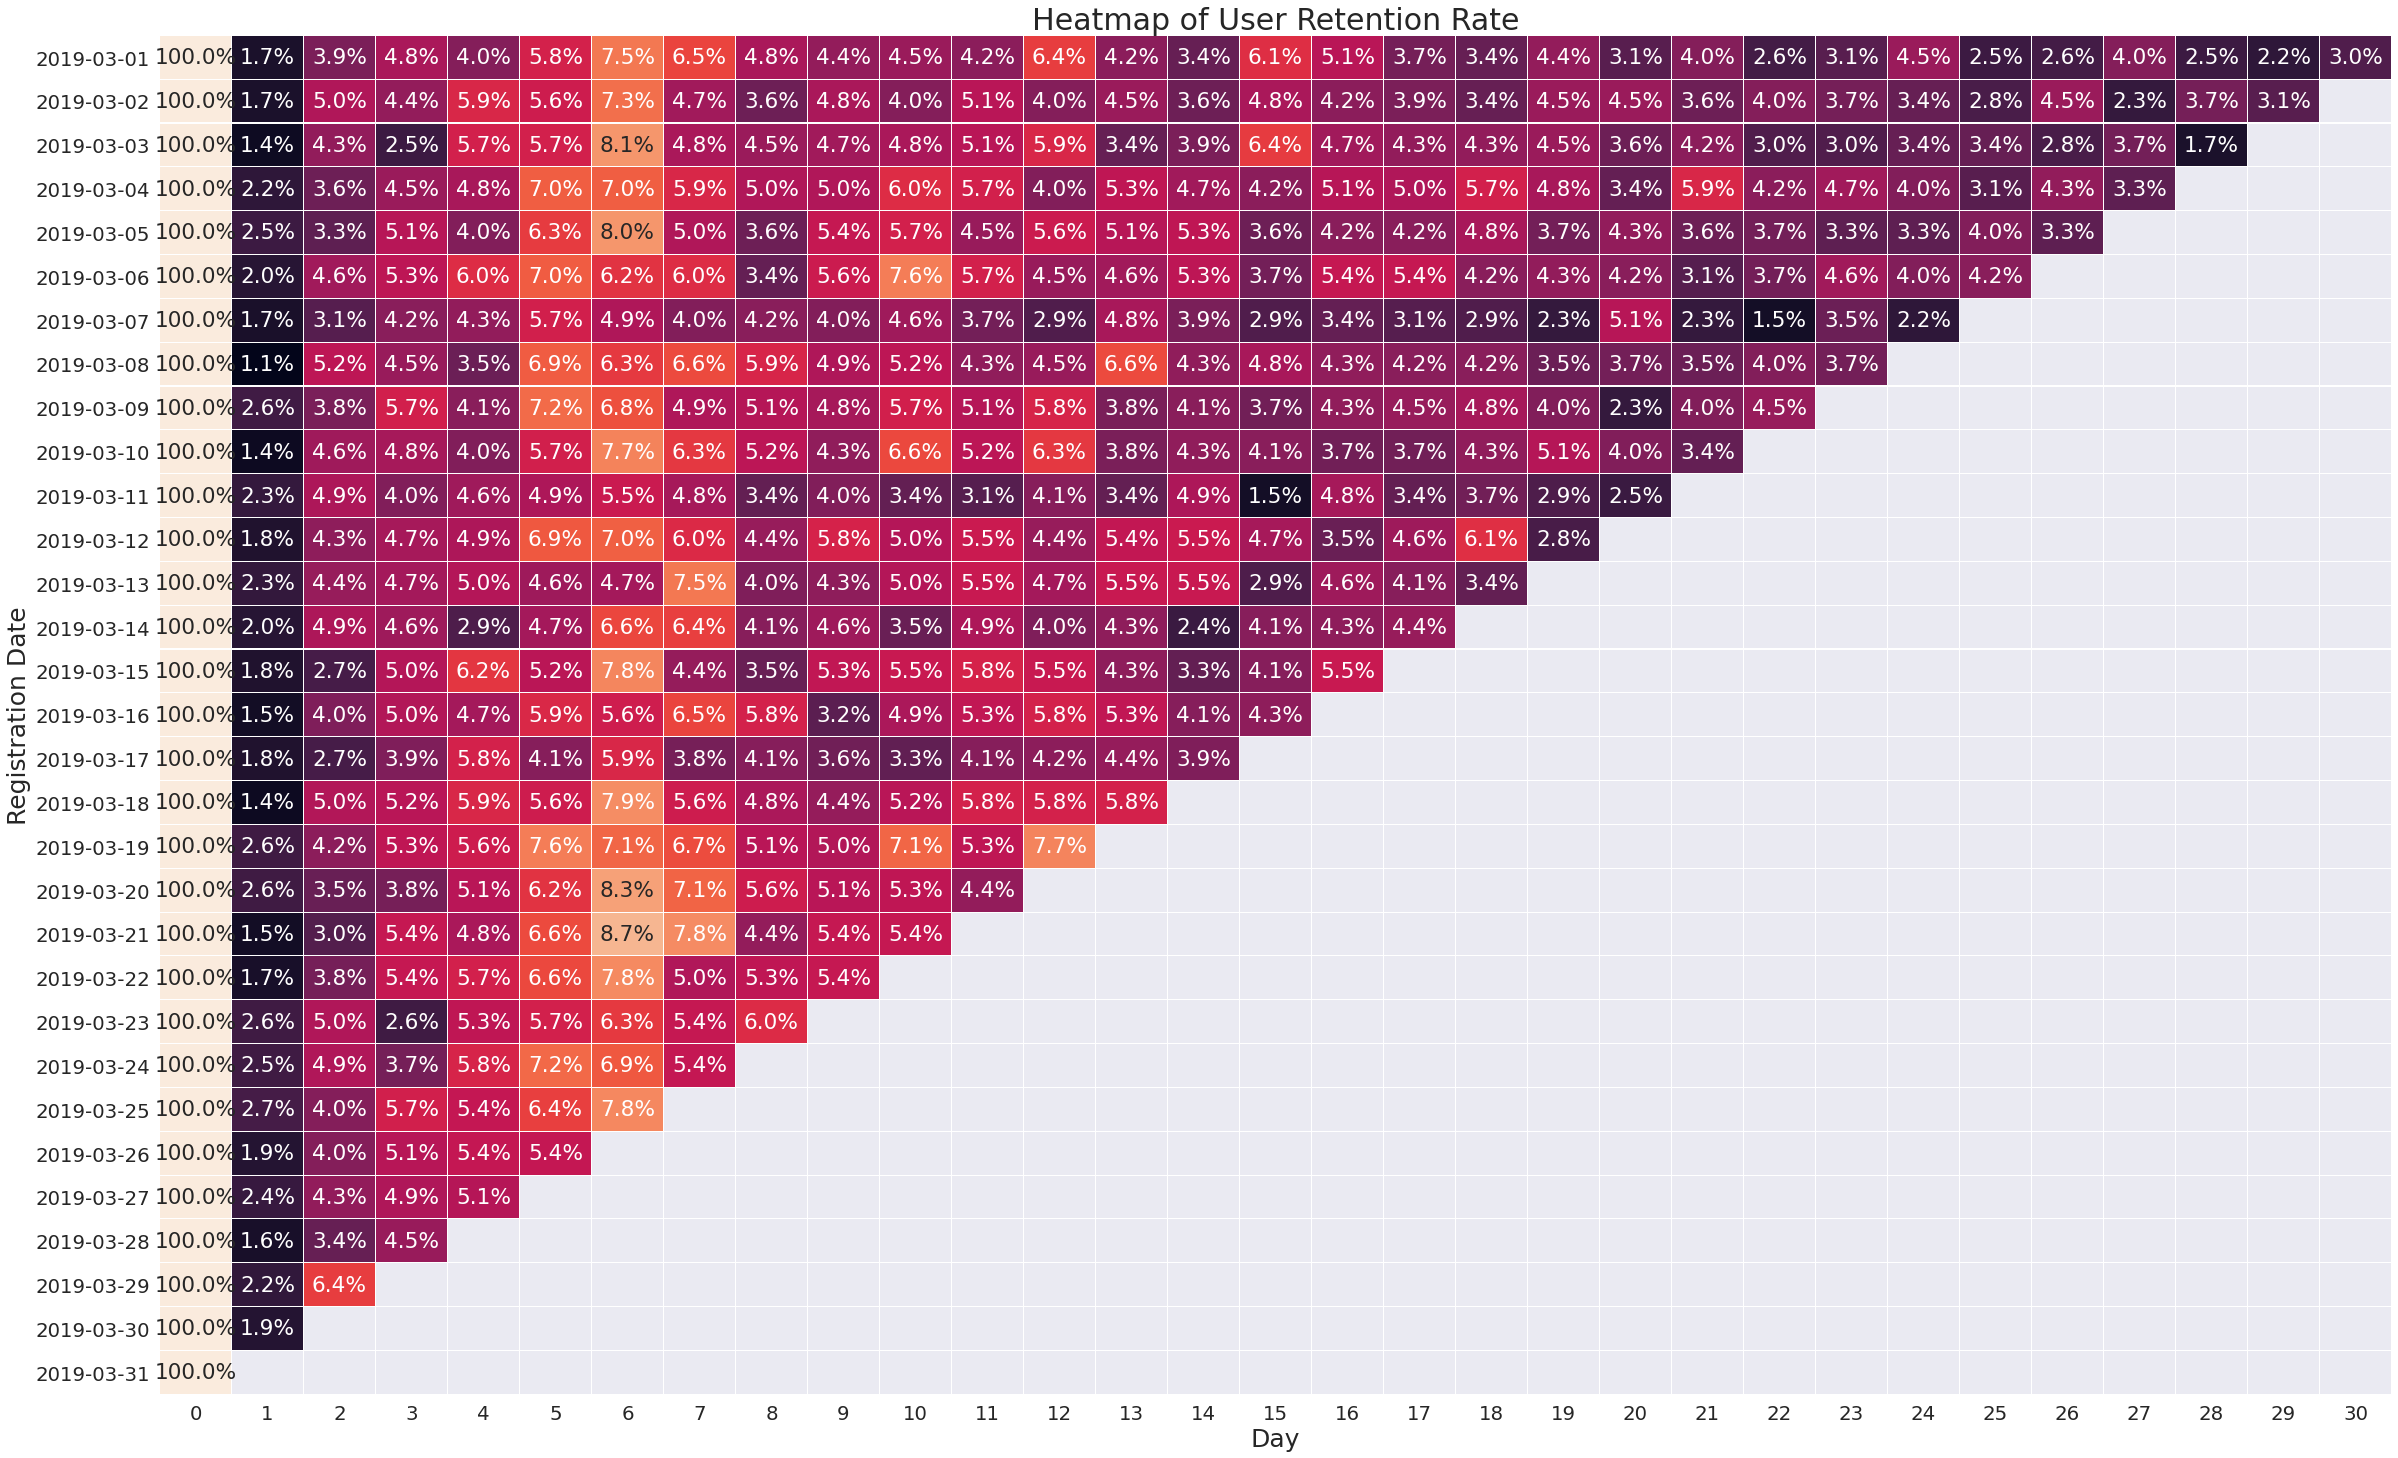

In [27]:
# построим heatmap
sns.set(style='ticks')
sns.set(font_scale=1.8)
plt.figure(figsize=(40, 25))
plt.title('Heatmap of User Retention Rate', fontsize=30)
sns.heatmap(ur.T, mask=ur.T.isnull(), annot=True, fmt='.1%', linewidths=0.1, cbar=False, vmax=0.1)
plt.xlabel('Day', fontsize=25)
plt.ylabel('Registration Date', fontsize=25)

In [ ]:
# тест 2 - узнать retention в период с 22 августа по 31 августа 2019 года
ur2 = ret_rate_cohort_period(df_reg_data, df_auth_data, start_date='2015-08-22', stop_date='2015-09-01')

In [ ]:
# построим heatmap
sns.set(style='ticks')
sns.set(font_scale=1.8)
plt.figure(figsize=(20, 16))
plt.title('Heatmap of User Retention Rate', fontsize=30)
sns.heatmap(ur2.T, mask=ur2.T.isnull(), annot=True, fmt='.1%', linewidths=0.1, cbar=False, vmax=0.1)
plt.xlabel('Day', fontsize=25)
plt.ylabel('Registration Date', fontsize=25)